<a href="https://colab.research.google.com/github/tylerheadley/Movie-Recommender-NMF/blob/main/MovieRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Movie Recommender System
###Shreya Balaji, Tyler Headley, and Bryce Tu Chi

Final project for MATH189: Mathematical Data Science & Topic Modeling.

We develop an algorithm to recommend new movies to users based on known
preferences for already seen movies. To accomplish this, we use collaborative filtering (CF), a technique commonly employed in recommender systems to predict the user ratings of items based on known ratings of related items. One established way to implement collaborative filtering is using non-negative matrix factorization (NMF) because the learned low rank approximation of matrix factors preserves latent structure in the data while ensuring the entries retain their meaning in the context of the data. Our CF-based algorithm will use a modified NMF model trained on a dataset of over 600 user preferences for almost 10,000 movies, to predict the movies in the dataset individual users would have the strongest affinity for. However, due to the extreme sparsity of the data (no user has seen all 9737 movies in the dataset), it is necessary to modify NMF to reach our objective of imputing the originally missing ratings. Additionally, we address the problem of introducing new users to the system by creating an algorithm that will add them to the matrix factorization without needing to refactor the entire
system.

In [28]:
#@title Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math

To train and expirement with our NMF model, we will use ["Movie Recommender System Dataset"](https://www.kaggle.com/datasets/gargmanas/movierecommenderdataset?select=movies.csv) from Kaggle.

In [3]:
#@title Load dataset into Pandas DataFrames
movies_df = pd.read_csv('https://raw.githubusercontent.com/tylerheadley/Movie-Recommender-NMF/main/Data/movies.csv')
ratings_df = pd.read_csv('https://raw.githubusercontent.com/tylerheadley/Movie-Recommender-NMF/main/Data/ratings.csv')



#Data Exploration
Now we'll do some data exploration and visualization to get to know our dataset better. We'll start out by taking a look at the sampling distribution for the ratings given to movies in the dataset, which are multiples of 0.5 ranging from 0.5 to 5.0.

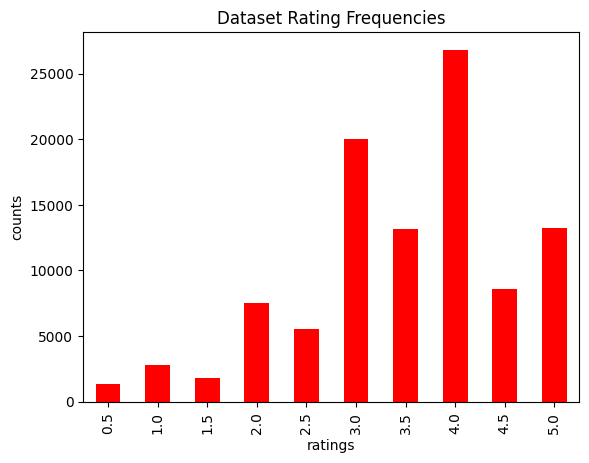

In [4]:
#@title Plot rating frequencies in our dataset
ratings_df['rating'].value_counts().sort_index().plot(kind="bar", color='red')

# add labels and title
plt.xlabel('ratings')
plt.ylabel('counts')
plt.title('Dataset Rating Frequencies')

plt.show()

Next, we'll dig into the movies dataset and explore what genres of movies are present.

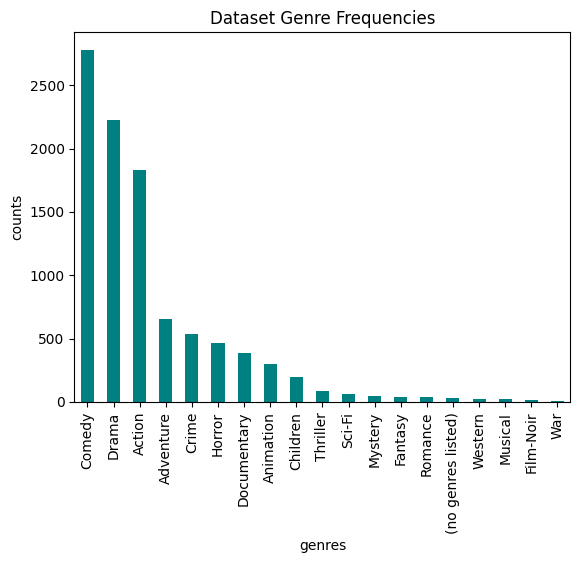

In [5]:
# @title Plot movie genre frequencies in our dataset
# movies are tagged with multiple genres listed in one column, separated by "|"
categories = movies_df['genres'].str.split("|", expand=True) # create dataframe with a separate column for each genre
category_counts = categories[0].value_counts() # initialize category counts

for i in range(1, categories.shape[1]):
  # if new genre not already in Series, initialize it to zero
  category_counts.add(categories[i].value_counts(), fill_value=0)

# create bar plot
category_counts.plot(kind="bar", color='teal')

# add labels and title
plt.xlabel('genres')
plt.ylabel('counts')
plt.title('Dataset Genre Frequencies')

plt.show()

#Data Processing#
The next step is to prepare the data in the Pandas dataframes for NMF. This means we first need to construct a User-Item Rating Matrix which will be used in the collaborative filtering algorithm.

In [6]:
def dataframesToMatrix(movies_df, ratings_df, validation_partition: float = 0.1):
  '''Function to convert movie and rating dataframes into numpy data matrix for NMF.'''

  numUsers = ratings_df.loc[ratings_df.shape[0] - 1, 'userId'] # final user ID
  numMovies = movies_df.shape[0]
  numRatings = ratings_df.shape[0]

  # create matrix with dimensions |Users| X |Movies|
  rating_matrix = np.zeros((numUsers, numMovies))

  # keep track of where ratings are stored in matrix to easily iterate over known ratings later
  training_set = []

  # initialize validation set to later assess prediction accuracy
  validation_set = []

  # initialize array containing number of items each user has rated
  item_rating_counts = np.zeros(rating_matrix.shape[0])

  # initialize array containing number of users who have rated each item
  user_rating_counts = np.zeros(rating_matrix.shape[1])

  validation_set_size = validation_partition * numRatings

  # for each rating given to a movie by a user, set the entry at the corresponding location in the matrix to that rating
  # otherwise, the entry will remain zero
  for index, row in ratings_df.iterrows():
    userIndex = int(row['userId']) - 1 # 610 users, each with unique IDs from 1 to 610 (no gaps)
    movieIndex = movies_df.index[movies_df['movieId'] == row['movieId']].tolist()[0] # 9742 movies with unique IDs from 1 to 193609 (not consecutive)

    isValidation = (random.random() <= (validation_set_size - len(validation_set))/(numRatings - index))
    if isValidation:
      validation_set.append((row['rating'], userIndex, movieIndex))
    else:
      # place rating value at corresponding index in matrix
      rating_matrix[userIndex][movieIndex] = row['rating']

      training_set.append((userIndex, movieIndex))

      item_rating_counts[userIndex] += 1
      user_rating_counts[movieIndex] += 1

  return rating_matrix, training_set, validation_set, item_rating_counts, user_rating_counts


rating_matrix, training_set, validation_set, item_rating_counts, user_rating_counts = dataframesToMatrix(movies_df, ratings_df)

print(rating_matrix)
print("number of non-zero entries =", np.count_nonzero(rating_matrix))
print("total number of entries =", rating_matrix.shape[0]*rating_matrix.shape[1])
print("sparsity =", 1 - (np.count_nonzero(rating_matrix)/(rating_matrix.shape[0]*rating_matrix.shape[1])))

[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]
number of non-zero entries = 90752
total number of entries = 5942620
sparsity = 0.9847286213824878


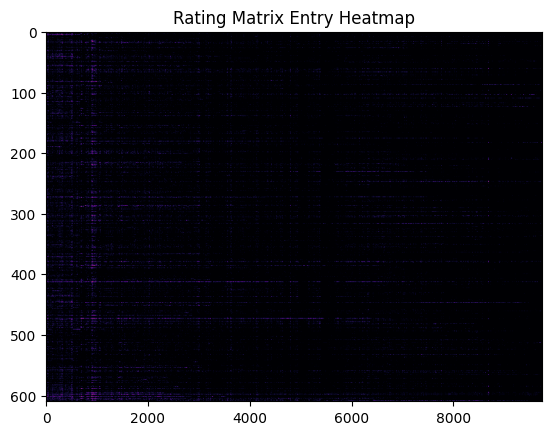

In [7]:
# display values of matrix entries by index
plt.imshow(rating_matrix, aspect='auto', cmap="inferno")
plt.title('Rating Matrix Entry Heatmap')
plt.show()

We can see that our rating matrix exhibits a high degree of sparsity, which is a characteristic trait of collaborative filtering problems. As a result of this, the multiplicative updates derived by Lee and Seung that are commonly used for NMF will not be as effective for our problem. We will compare the performance of their multiplicative updates with our own algorithm that includes a regularization term to encourage the factor matrices to remain sparse, which should prove more effective at giving movie recommendations.

#Training a Model
We are now ready to learn a low-rank factorization for the user-item rating matrix we've constructed. We will start out by using the popular multiplicative update algorithm proposed by Lee and Seung, which Prof. Haddock implemented in a previous tutorial. We will then attempt to improve on this algorithm for our application by adding in a regularization term, which will encourage sparsity.

In [8]:
#@title Define Progress Bar
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <div>Training Completion:</div>
        <progress
            value='{value}'
            max='{max}',
            style='width: 20%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# out = display(progress(0, 100), display_id=True)
# for ii in range(101):
#     time.sleep(0.02)
#     out.update(progress(ii, 100))

In [9]:
def rmse(R_hat, validation_set):
  validation_set_size = len(validation_set)
  sum = 0
  for rating in validation_set:
    sum += (rating[0] - R_hat[rating[1]][rating[2]])**2

  return math.sqrt(sum/validation_set_size)

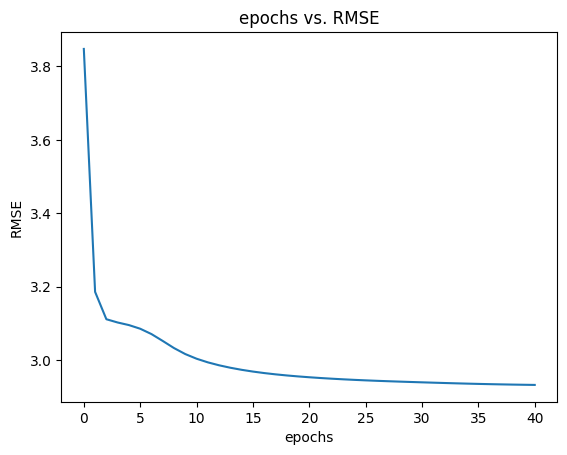

In [10]:
# code from Prof Haddock's multiplicative updates tutorial, adapted to work with our data matrix
# we will improve on this algorithm by encouraging the factor matrices to remain sparse
def mult_ups(X, validation_set, k, M = 10):
  eps_divide = 1e-6                                                 #define a small number to ensure we never divide by 0
  m,N = np.shape(X)                                                 #determine the size of X for initializing A and S

  if M < 1:
    raise Exception("Not a valid number of iterations.")            #error if number of iterations is less than 1

  A = np.abs(np.random.randn(m,k))                                  #initialize factor matrices
  S = np.abs(np.random.randn(k,N))

  fro_errors = [np.linalg.norm(X-A@S,'fro')**2]                         #initialize error array
  rmse_errors = [rmse(A@S, validation_set)]

  out = display(progress(0, M), display_id=True)
  for i in range(M):
    A = A*((X@np.transpose(S))/(A@S@np.transpose(S) + eps_divide))   #update for A
    S = S*((np.transpose(A)@X)/(np.transpose(A)@A@S + eps_divide))  #update for S

    fro_errors.append(np.linalg.norm(X-A@S,'fro')**2)                   #record error
    rmse_errors.append(rmse(A@S, validation_set))

    out.update(progress(i+1, M))

  return A, S, np.array(fro_errors), rmse_errors

P, Q, fro_errors, rmse_errors = mult_ups(rating_matrix, validation_set, 10, M = 40)
X_hat = P@Q

plt.plot(range(len(rmse_errors)), rmse_errors)

# add labels and title
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.title('epochs vs. RMSE')

plt.show()

number of non-zero entries = 5716920
number of entries > 0.5 = 167307
total number of entries = 5942620
sparsity = 0.03797988092794091


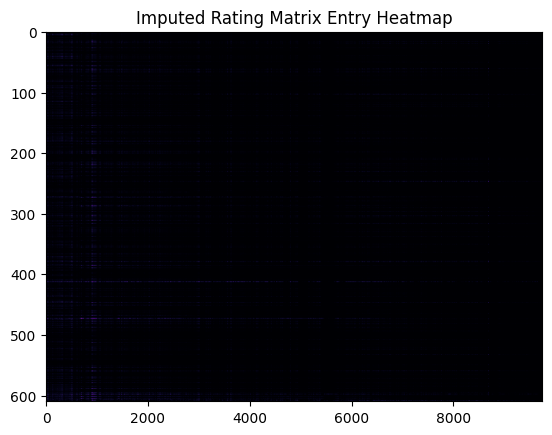

Min Rating Prediction: 0.0
25% Rating Prediction: 9.855142513194004e-05
Mean Rating Prediction: 0.06459429393544872
Median Rating Prediction: 0.004253370095920488
75% Rating Prediction: 0.029086094942394135
Max Rating Prediction: 9.52882505527903


In [11]:
# display values of matrix entries by index
print("number of non-zero entries =", np.count_nonzero(X_hat))
print("number of entries > 0.5 =", np.count_nonzero(np.floor(X_hat * 2)))
print("total number of entries =", X_hat.shape[0]*X_hat.shape[1])
print("sparsity =", 1 - (np.count_nonzero(X_hat)/(X_hat.shape[0]*X_hat.shape[1])))

plt.imshow(X_hat, aspect='auto', cmap="inferno")
plt.title('Imputed Rating Matrix Entry Heatmap')
plt.show()

# summarize rating prediction statistics
print(f"Min Rating Prediction: {np.min(X_hat)}")
print(f"25% Rating Prediction: {np.percentile(X_hat, 25)}")
print(f"Mean Rating Prediction: {np.mean(X_hat)}")
print(f"Median Rating Prediction: {np.median(X_hat)}")
print(f"75% Rating Prediction: {np.percentile(X_hat, 75)}")
print(f"Max Rating Prediction: {np.max(X_hat)}")

Although the matrix is much denser than before, most of the non-zero values are very small.

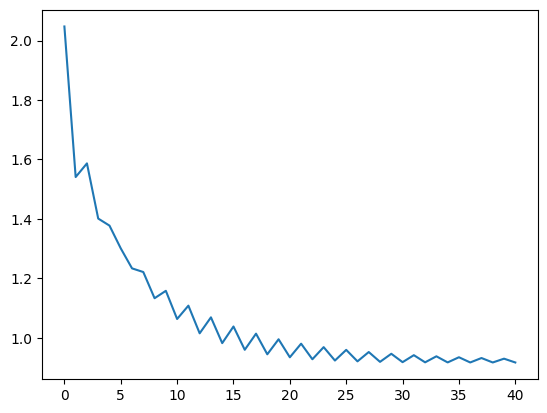

In [12]:
# f is the feature matrix dimension
def nmf_cf(R, f, training_set, item_rating_counts, user_rating_counts, validation_set, lambda_P = .06, lambda_Q = .06, max_training_round = 10):
  # initialize factor matrices
  P = np.random.rand(R.shape[0], f)
  Q = np.random.rand(f, R.shape[1])

  #define a small number to ensure we never divide by 0
  eps_divide = 1e-6

  # initialize auxiliary matrices (used to store intermediate values)
  UserUP = np.zeros((R.shape[0], f))
  UserDOWN = np.zeros((R.shape[0], f))
  ItemUP = np.zeros((f, R.shape[1]))
  ItemDOWN = np.zeros((f, R.shape[1]))

  training_round = 0

  # keep track of error between actual matrix and predicted values
  errors = [rmse(P@Q, validation_set)]

  # create progress bar
  out = display(progress(0, max_training_round), display_id=True)

  while training_round != max_training_round: # could also check if model has converged
    # reset matrices to zero
    UserUP.fill(eps_divide)
    UserDOWN.fill(eps_divide)
    ItemUP.fill(eps_divide)
    ItemDOWN.fill(eps_divide)

    R_hat = P@Q
    for rating in training_set:
      u = int(rating[0])
      i = int(rating[1])
      # if there is a rating of movie i by user u
      for k in range(f):
        # update auxiliary matrices
        UserUP[u][k] = UserUP[u][k] + Q[k][i] * R[u][i]
        UserDOWN[u][k] = UserDOWN[u][k] + Q[k][i] * R_hat[u][i]
        ItemUP[k][i] = ItemUP[k][i] + P[u][k] * R[u][i]
        ItemDOWN[k][i] = ItemDOWN[k][i] + P[u][k] * R_hat[u][i]

    for u in range(R.shape[0]):
      for k in range(f):
        UserDOWN[u][k] = UserDOWN[u][k] + item_rating_counts[u] * lambda_P * P[u][k]

    # perform multiplicative update for P
    P = P*(UserUP/UserDOWN)

    for i in range(R.shape[1]):
      for k in range(f):
        ItemDOWN[k][i] = ItemDOWN[k][i] + user_rating_counts[i] * lambda_Q * Q[k][i]

    # perform multiplicative update for Q
    Q = Q*(ItemUP/ItemDOWN)

    # record error
    errors.append(rmse(P@Q, validation_set))

    training_round += 1

    # update progress bar
    out.update(progress(training_round, max_training_round))


  return P, Q, errors

P, Q, errors = nmf_cf(rating_matrix, 20, training_set, item_rating_counts, user_rating_counts, validation_set, lambda_P = .12, lambda_Q = .12, max_training_round = 40)
R_hat = P@Q

plt.plot(range(len(errors)), errors)

number of non-zero entries = 5942620
number of entries > 0.5 = 5906612
total number of entries = 5942620
sparsity = 0.0


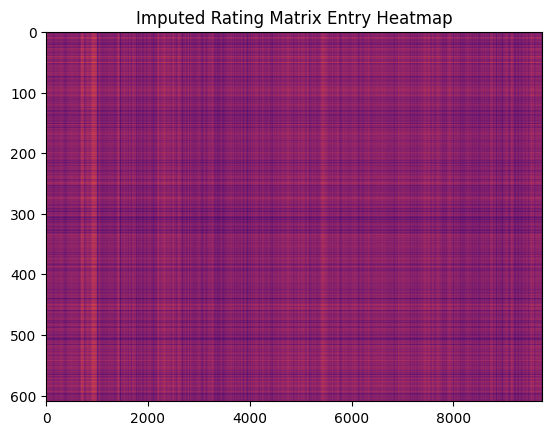

Min Rating Prediction: 0.08456639381930979
25% Rating Prediction: 2.609488898504104
Mean Rating Prediction: 3.1576943384072127
Median Rating Prediction: 3.2278650513119667
75% Rating Prediction: 3.7770308997437736
Max Rating Prediction: 8.37423394334237


In [13]:
print("number of non-zero entries =", np.count_nonzero(R_hat))
print("number of entries > 0.5 =", np.count_nonzero(np.floor(R_hat * 2)))
print("total number of entries =", R_hat.shape[0]*R_hat.shape[1])
print("sparsity =", 1 - (np.count_nonzero(R_hat)/(R_hat.shape[0]*R_hat.shape[1])))

# display values of matrix entries by index
plt.imshow(R_hat, aspect='auto', cmap="inferno")
plt.title('Imputed Rating Matrix Entry Heatmap')
plt.show()

# summarize rating prediction statistics
print(f"Min Rating Prediction: {np.min(R_hat)}")
print(f"25% Rating Prediction: {np.percentile(R_hat, 25)}")
print(f"Mean Rating Prediction: {np.mean(R_hat)}")
print(f"Median Rating Prediction: {np.median(R_hat)}")
print(f"75% Rating Prediction: {np.percentile(R_hat, 75)}")
print(f"Max Rating Prediction: {np.max(R_hat)}")

We can see that performing our regularized NMF on the original rating matrix and then multiplying the learned factors back together has filled in the zeros in the original rating matrix. We can now create an algorithm that uses these filled in rating predictions to suggest new movies to any given user in the system.  

In [15]:
def recommendations(R_hat, R, movies_df, user_index, num_recommendations = 5, check_if_seen = True):
  # initialize array of movies indices
  recommendations = np.zeros(num_recommendations)

  # initialize array of predicted ratings
  recommendation_rating_predictions = np.zeros(num_recommendations)

  # iterate over all movies in the dataset
  for movie_index in range(R_hat.shape[1]):
    rating_prediction = R_hat[user_index][movie_index]

    # check if the user has already seen the movie, only recommend new movies
    # also check if the predicted rating is higher than any of our recommendations so far
    if (R[user_index][movie_index] == 0 or not check_if_seen) and rating_prediction > recommendation_rating_predictions[-1]:
      # maintain order of recommendation ratings so that top recommendation comes first
      i = 0
      while (rating_prediction < recommendation_rating_predictions[i]):
        i += 1
      # keep track of index and rating values
      recommendations = np.insert(recommendations, i, movie_index)[:num_recommendations]
      recommendation_rating_predictions = np.insert(recommendation_rating_predictions, i, rating_prediction)[:num_recommendations]

  # return movie titles corresponding to indices
  return [movies_df.iloc[int(movie_index)]["title"] for movie_index in recommendations], recommendations, recommendation_rating_predictions


print("Example Known user preferences: ", recommendations(rating_matrix, rating_matrix, movies_df, 3, check_if_seen = False)[0])
print("Our recommendations:", recommendations(R_hat, rating_matrix, movies_df, 3)[0])
print("Standard multiplicative update recommendations (Prof Haddock's mult_ups algorithm):", recommendations(X_hat, rating_matrix, movies_df, 3)[0])

Example Known user preferences:  ['Eat Drink Man Woman (Yin shi nan nu) (1994)', 'Before Sunrise (1995)', 'Living in Oblivion (1995)', 'Crumb (1994)', 'Flirting With Disaster (1996)']
Our recommendations: ['Ace in the Hole (Big Carnival, The) (1951)', 'Eddie Izzard: Glorious (1997)', 'This Gun for Hire (1942)', 'Sunset Park (1996)', 'Schizopolis (1996)']
Standard multiplicative update recommendations (Prof Haddock's mult_ups algorithm): ['Star Wars: Episode V - The Empire Strikes Back (1980)', 'Godfather, The (1972)', 'Apocalypse Now (1979)', 'Alien (1979)', 'Blade Runner (1982)']


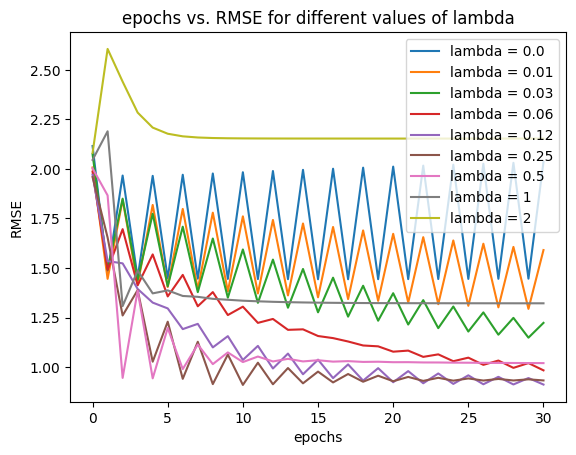

In [62]:
# experiment with RMSE for different values of lambda
for lambda_P_Q in [0.0, .01, .03, .06, .12, .25, .5, 1, 2]:
  P, Q, errors = nmf_cf(rating_matrix, 20, training_set, item_rating_counts, user_rating_counts, validation_set, lambda_P = lambda_P_Q, lambda_Q = lambda_P_Q, max_training_round = 30)

  plt.plot(range(len(errors)), errors, label=f"λ = {lambda_P_Q}")

# add labels and title
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.title('epochs vs. RMSE for different values of lambda')
plt.legend(loc='upper right')

plt.show()

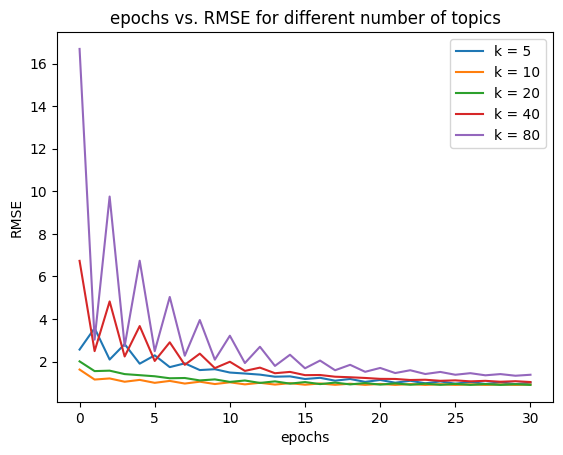

In [64]:
for k in [5, 10, 20, 40, 80]:
  P, Q, errors = nmf_cf(rating_matrix, k, training_set, item_rating_counts, user_rating_counts, validation_set, lambda_P = .12, lambda_Q = .12, max_training_round = 30)

  plt.plot(range(len(errors)), errors, label=f"k = {k}")

# add labels and title
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.title('epochs vs. RMSE for different number of topics')
plt.legend(loc='upper right')

plt.show()

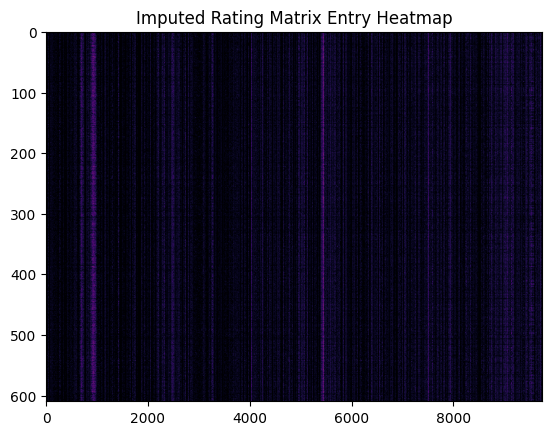

In [26]:
recommendation_matrix = np.zeros((R_hat.shape[0], R_hat.shape[1]))
out = display(progress(0, R_hat.shape[0]), display_id=True)

for user in range(R_hat.shape[0]):
  recommendation_titles, recommendation_indices, recommendation_rating_predictions = recommendations(R_hat, rating_matrix, movies_df, user, num_recommendations = 900)

  out.update(progress(user, R_hat.shape[0]))
  for i in range(len(recommendation_indices)):
    movie = int(recommendation_indices[i])

    recommendation_matrix[user][movie] = recommendation_rating_predictions[i]


# display values of matrix entries by index
plt.imshow(recommendation_matrix, aspect='auto', cmap="inferno")
plt.title('Imputed Rating Matrix Entry Heatmap')
plt.show()

In [27]:
print("number of non-zero entries =", np.count_nonzero(recommendation_matrix))
print("number of entries > 0.5 =", np.count_nonzero(np.floor(recommendation_matrix * 2)))
print("total number of entries =", recommendation_matrix.shape[0]*recommendation_matrix.shape[1])
print("sparsity =", 1 - (np.count_nonzero(recommendation_matrix)/(recommendation_matrix.shape[0]*recommendation_matrix.shape[1])))

number of non-zero entries = 549000
number of entries > 0.5 = 549000
total number of entries = 5942620
sparsity = 0.9076165058509547


#Incorporating New Users

In [ ]:
# f is the feature matrix dimension
def new_user(R, r_new, Q, training_set, item_rating_counts, user_rating_counts, validation_set, lambda_P = .06, lambda_Q = .06, max_training_round = 10):
  # r_new = np.atleast2d(r_new).T # turn vector into 2D row

  # initialize new row for new user u in for user matrix P
  p_u = np.random.rand(1, f)

  #define a small number to ensure we never divide by 0
  eps_divide = 1e-6

  # initialize auxiliary matrices (used to store intermediate values)
  UserUP = np.zeros((1, f))
  UserDOWN = np.zeros((1, f))

  training_round = 0

  # # keep track of error between actual matrix and predicted values
  # errors = [rmse(P@Q, validation_set)]

  # create progress bar
  out = display(progress(0, max_training_round), display_id=True)

  while training_round != max_training_round: # could also check if model has converged
    # reset matrices to zero
    UserUP.fill(eps_divide)
    UserDOWN.fill(eps_divide)

    r_hat = p_u@Q
    for rating in training_set:
      i = int(rating[1])
      # if there is a rating of movie i by user u
      for k in range(f):
        # update auxiliary matrices
        UserUP[0][k] = UserUP[0][k] + Q[k][i] * r_new[i]
        UserDOWN[0][k] = UserDOWN[0][k] + Q[k][i] * r_new[i]
        # ItemUP[k][i] = ItemUP[k][i] + P[u][k] * R[u][i]
        # ItemDOWN[k][i] = ItemDOWN[k][i] + P[u][k] * R_hat[u][i]

    for u in range(R.shape[0]):
      for k in range(f):
        UserDOWN[u][k] = UserDOWN[u][k] + item_rating_counts[u] * lambda_P * P[u][k]

    # perform multiplicative update for P
    P = P*(UserUP/UserDOWN)

    for i in range(R.shape[1]):
      for k in range(f):
        ItemDOWN[k][i] = ItemDOWN[k][i] + user_rating_counts[i] * lambda_Q * Q[k][i]

    # perform multiplicative update for Q
    Q = Q*(ItemUP/ItemDOWN)

    # record error
    errors.append(rmse(P@Q, validation_set))

    training_round += 1

    # update progress bar
    out.update(progress(training_round, max_training_round))


  return P, Q, errors

P, Q, errors = nmf_cf(rating_matrix, 20, training_set, item_rating_counts, user_rating_counts, validation_set, lambda_P = .12, lambda_Q = .12, max_training_round = 40)
R_hat = P@Q

plt.plot(range(len(errors)), errors)